In [17]:
#VGG-16code
#Import Necessary packages(?)

import os   #In python, use to copy files, make directory, change directory etc
import torch
import torch.nn as nn #nn stands for neural networks --> use attribute to make states
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision        #torch vision packages include datasets, model architecture, image transformation etc
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader

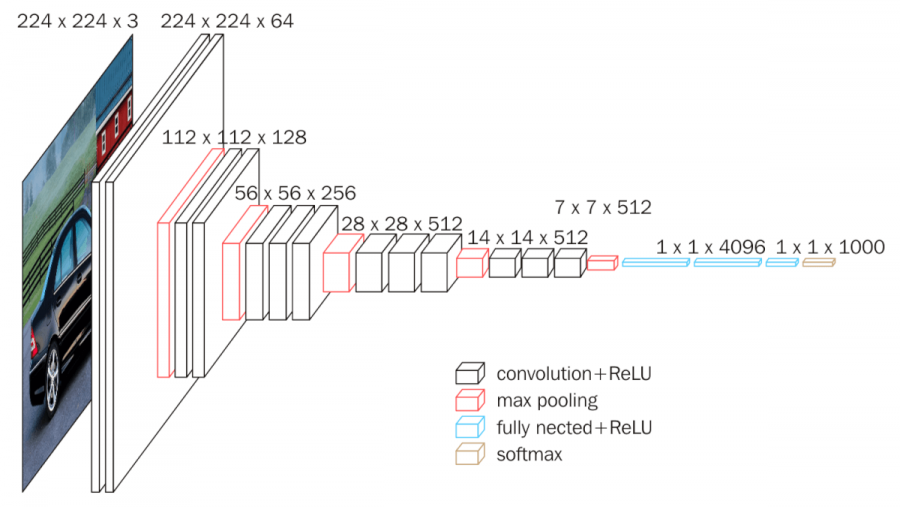

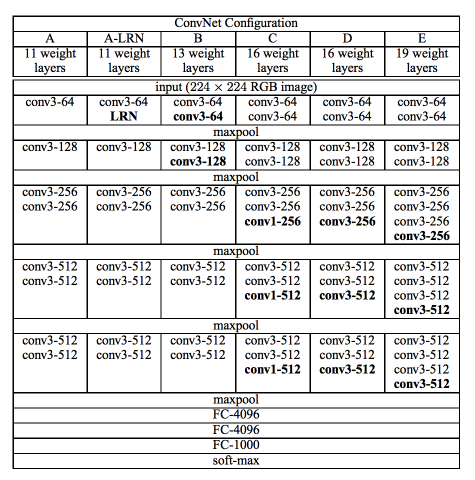

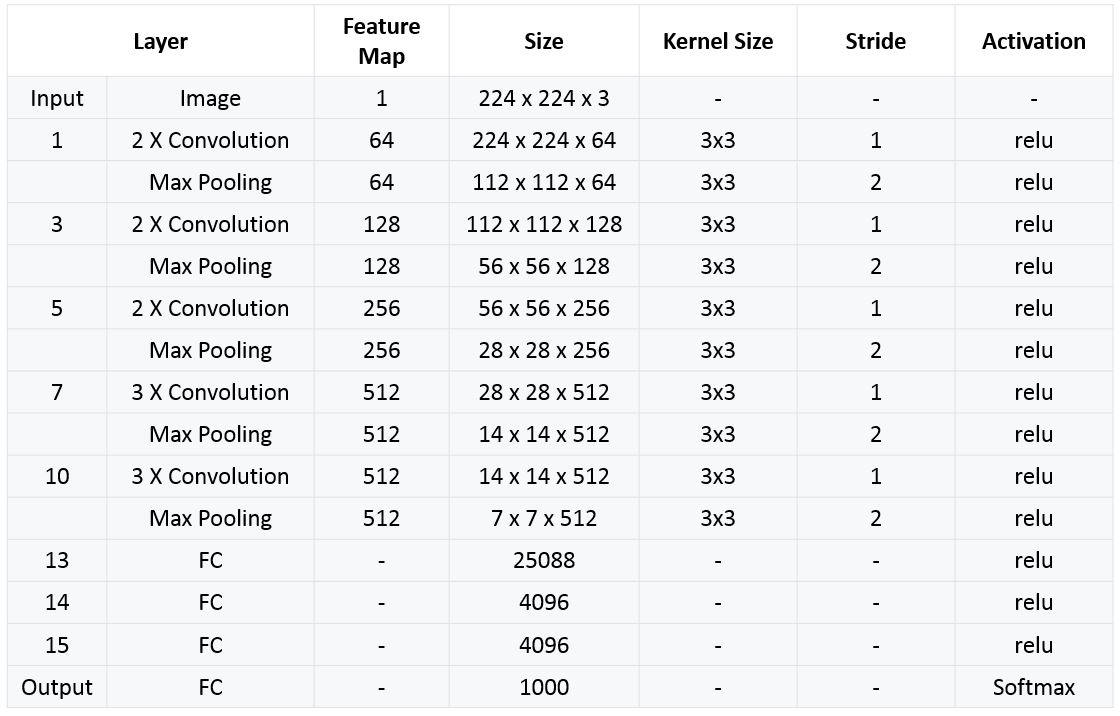

In [11]:
#VGGNet Architecture
import os 
os.getcwd() #check current directory
os.chdir('/Users/jaehyoyi/Desktop/') # move to Desktop directory
from IPython.display import Image, display
#cd /Users/jaehyoyi/Desktop
display(Image(filename='VGG.png'))
#picture from : https://blog.kakaocdn.net/dn/K990l/btqwDJ7C54R/664Ksm6gyTGBR1wK3YPDFk/img.png
display(Image(filename='VGG2.png'))
#picture from : https://pytorch.org/assets/images/vgg.png
display(Image(filename='VGG3.png'))
#picture from : https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide

Output feature map size calculation

O = (I-F+2P)/S + 1

I : input feature map size

F : size of filter(kernel size) 3x3

P : padding, fill out edges

S : unit for how much convolution moves each time

In [34]:
#Define Convolutional block with 2 layers
#Reference from : https://velog.io/@euisuk-chung/파이토치-파이토치로-CNN-모델을-구현해보자-VGGNet편

def conv_2_block(in_dim, out_dim):
    #for example, in_dim = 224, out_dim = 112 
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2) #this reduces size of channel to half 
    )
    return model

#Note that for example 224-3+2/1 +1  = 224 which feature map size stays the same
#We add Maxpool layer at the end to 

In [33]:
#Define Convolutional block with 3 layers

def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model


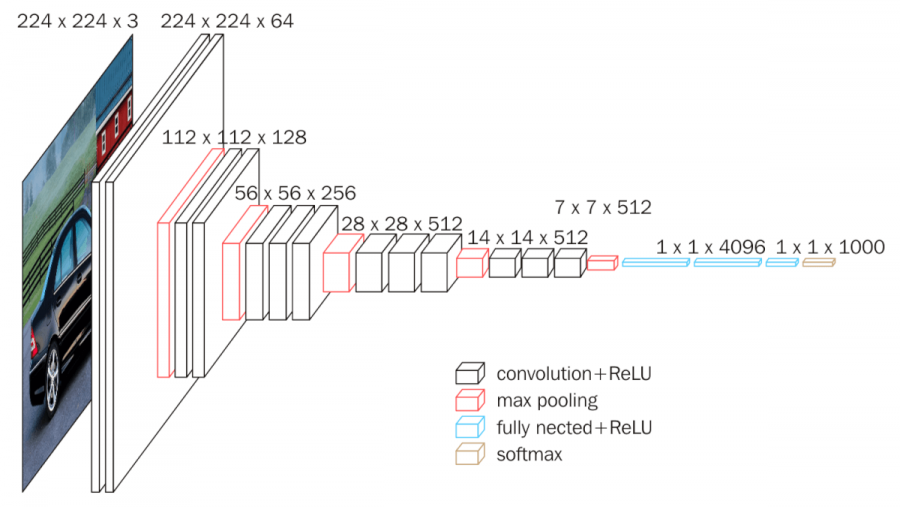

In [30]:
from IPython.display import Image, display
display(Image(filename='VGG.png'))
#picture from : https://blog.kakaocdn.net/dn/K990l/btqwDJ7C54R/664Ksm6gyTGBR1wK3YPDFk/img.png

In [61]:
#Define VGG-16

class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=10):   #num_classes depends on which dataset you use
        super(VGG16, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3, base_dim), #64
            conv_2_block(base_dim, 2*base_dim), #128
            conv_3_block(2*base_dim, 4*base_dim), #256
            conv_3_block(4*base_dim, 8*base_dim), #512
            conv_3_block(8*base_dim, 8*base_dim), #512
        )
        #FC layer at the end for classifier
        self.fc_layer = nn.Sequential(
            #Note CIFAR-10 input is 32x32
            nn.Linear(8*base_dim*1*1, 4096), #1*1 is multiplied for Fully Connected layer <-- not sure, look up for more information
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )
        
    def forward(self,x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)  #reform the size of x to (x(0), ?), ? stands for fit number
        #For example 3 dimension tensor with x=4x4x3 --> x.view([-1, 3]) stands for change it to 2 dimension (16,3)
        #print(x.shape)
        x = self.fc_layer(x)
        return x
    


In [35]:
#Define model, loss, optimizer
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )

# Make VGG class as a instance(?) <-- search for more meaning later
model = VGG16(base_dim=64).to(device)

#Define loss and optimizer
batch_size = 100
learning_rate = 0.0002
num_epoch = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [43]:
#Load CIFAR10 dataset
#CIFAR-10 dataset contains 10 different classes such as airplane, automible, bird, etc...
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#Define transforms

transform  = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))   #Normalize([mean1, mean2, mean3], [std1, std2, std3])
     #normalize is used since pixel value 0~255 is transformed to 0~1, however we need this value to be in between -1~1
     ])

#Define CIFAR10 train set
cifar10_train = datasets.CIFAR10(root="../Data/", train = True, transform=transform,  target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Define CIFAR10 test set
cifar10_test = datasets.CIFAR10(root="../Data/", train = False, transform=transform,  target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


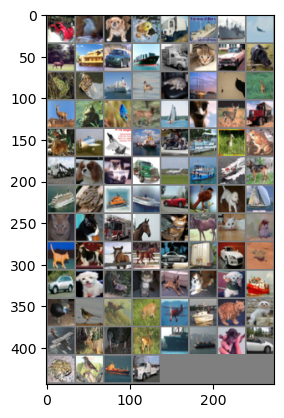

car   bird  dog   frog  truck ship  ship  plane deer  ship  car   ship  truck cat   car   dog   frog  frog  ship  bird  cat   ship  cat   deer  deer  frog  bird  deer  ship  bird  deer  truck deer  plane plane ship  car   ship  bird  frog  truck dog   ship  truck plane ship  ship  dog   ship  frog  ship  ship  car   bird  dog   ship  cat   cat   truck horse cat   horse cat   bird  cat   dog   horse horse car   truck car   frog  car   dog   deer  cat   dog   dog   dog   ship  bird  bird  deer  deer  plane ship  cat   dog   plane deer  bird  deer  ship  ship  dog   car   frog  bird  ship  truck


In [46]:
#Try to visualize some train dataset
#Refernce from pytorch tutorial : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

#function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    

In [60]:
#Define training

loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(trainloader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


NotImplementedError: Module [VGG16] is missing the required "forward" function

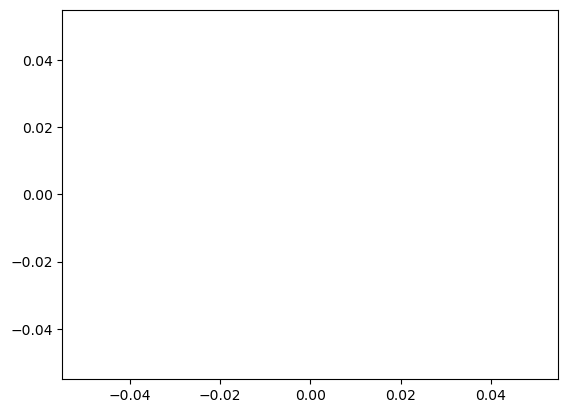

In [50]:
plt.plot(loss_arr)
plt.show()